<h1>Lesson 4. Model selection: Car mileage</h1>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/77/%22real_time_display%22_of_mileage_%28%22mpg%22%29_on_Honda_Insight.png/320px-%22real_time_display%22_of_mileage_%28%22mpg%22%29_on_Honda_Insight.png" style="height:200px;">
  
<p>In this exercise you will predict car mileage based on its properties. The data is taken from <a href="http://www-bcf.usc.edu/~gareth/ISL/">ISLR website</a>, but requires few transformations to make it usable for model building. These transformations will include: missing value imputation and normalizing the variables. </p>

<p>This dataset contains 397 car entries with following features:</p>
<ul>
<li>mpg miles per gallon (what we are trying to predict)</li>
<li>cylinders Number of cylinders between 4 and 8</li>
<li>displacement Engine displacement (cu. inches)</li>
<li>horsepower Engine horsepower</li>
<li>weight Vehicle weight (lbs.)</li>
<li>acceleration Time to accelerate from 0 to 60 mph (sec.)</li>
<li>year Model year (modulo 100)</li>
<li>origin Origin of car (1. American, 2. European, 3. Japanese)</li>
<li>name Vehicle name</ul>
</ul>


In [1]:
# Imports
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")
import pandas as pd
from sklearn import (
    ensemble,
    model_selection,    
    preprocessing,
    tree,
)
from sklearn.metrics import (
    auc,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
)

import pandas_profiling

# Load the data
auto = pd.read_csv('Auto.csv')
print(auto.info())
auto.head()

# emit profiling data
pandas_profiling.ProfileReport(auto)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 8 columns):
mpg             397 non-null float64
cylinders       397 non-null int64
displacement    397 non-null float64
horsepower      392 non-null float64
weight          397 non-null int64
acceleration    397 non-null float64
year            397 non-null int64
origin          397 non-null int64
dtypes: float64(4), int64(4)
memory usage: 24.9 KB
None


Number of variables,8
Number of observations,397
Total Missing (%),0.2%
Total size in memory,24.9 KiB
Average record size in memory,64.2 B
Numeric,6
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,2


<h3>Q.1. Write a command that will calculate the number of missing values in this dataset</h3>

In [15]:
# Command(s)
auto.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      5
weight          0
acceleration    0
year            0
origin          0
dtype: int64

<h3>Q.2. Write a command that will only show the rows with missing values. Can you comment on why the values might be missing (e.g. excessive prevalence of specific feature)?</h3>

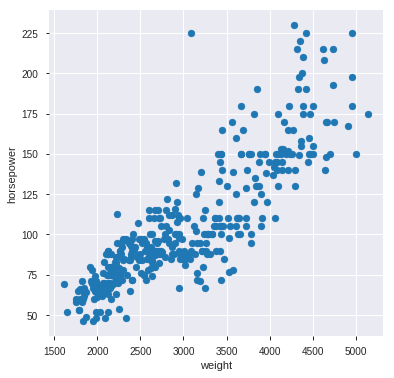

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
32,25.0,4,98.0,NaN,2046,19.0,71,1
126,21.0,6,200.0,NaN,2875,17.0,74,1
330,40.9,4,85.0,NaN,1835,17.3,80,2
336,23.6,4,140.0,NaN,2905,14.3,80,1
354,34.5,4,100.0,NaN,2320,15.8,81,2


In [17]:
# plot to show the relationship between weight and horsepower.
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(auto['weight'], auto['horsepower'])
ax.set_xlabel('weight')
ax.set_ylabel('horsepower')
plt.show()

# Command that will only show the rows with missing values:
null_data = auto[auto.isnull().any(axis=1)]
null_data


# Comment (One - two sentence)
# The specific reason why horsepower values are missing is unclear. Looks to be a case of MCAR.
# I notice that horsepower has a linear relationship with weight, displacement and cylinder. So we can find a good imputed value based on similar values.

<h3>Q.3. Impute the missing values using median for the column. Given answer to Q.2, is this a good approach to fix the missing value problem?</h3>

In [2]:
# Command(s):

meds = auto.median()
auto = auto.fillna(meds)

# make sure no missing values exist
auto.isnull().sum()

# Comment (one sentence):
# from the histogram of horsepower (look at the profiling result), we can see that a large majority of the horsepower values is present in the range of 75-100
# Median of horsepower is 93.5. When median is a decent solution for missing value problem, we could have done a better job at it.
# From profiling, we notice that horsepower is related to cylinders, displacement, weight. 
# Better solution would have been in trying to figure out the hosepower value for a similar cylinder/displacement/weight value.

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
year            0
origin          0
dtype: int64

<h3>Q.4. Develop a Linear Regression model that predicts mpg using all the available features in the data.frame. Summarize it and comment on its quality. </h3>

In [3]:
# Develop the model 
# Commands:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split 
import statsmodels.formula.api as smf
import numpy as np

X = auto[["cylinders", "displacement", "horsepower", "weight", "acceleration", "year", "origin"]].values

Y = auto['mpg'].values
Y

regressor = LinearRegression()
regressor.fit(X, Y)
print(regressor.coef_)
print(regressor.intercept_)

y_pred = regressor.predict(X)
print('Mean Absolute Error:', metrics.mean_absolute_error(Y, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(Y, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y, y_pred)))
print('R2 value:', metrics.r2_score(Y, y_pred))

#---------------------------------------------------------------------------------------------
### STATSMODELS ###

# create a fitted model with all the features
lm1 = smf.ols(formula='mpg ~ cylinders + displacement + horsepower + weight + acceleration + year + origin', data=auto[["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "year", "origin"]]).fit()

# print the coefficients
lm1.params

# print a summary of the fitted model
lm1.summary()

# Comment on its quality 
# Adjusted R-squared value is good. 
# Some of the features are highly correlated with each other. Would have been nice to check the performace if those features are removed.
# For eg, profiling suggests to remove displacement and weight as features.

[-0.44983357  0.01918346 -0.0110079  -0.00669786  0.11083624  0.76108151
  1.40573112]
-18.47403936864734
Mean Absolute Error: 2.508270990916763
Mean Squared Error: 10.892089955091894
Root Mean Squared Error: 3.3003166446709162
R2 value: 0.8217011201126686


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     256.1
Date:                Sat, 02 May 2020   Prob (F-statistic):          2.22e-141
Time:                        19:44:26   Log-Likelihood:                -1037.3
No. Observations:                 397   AIC:                             2091.
Df Residuals:                     389   BIC:                             2123.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -18.4740      4.621     -3.998      0.000     -27.559      -9.389
cylinders       -0.4498      0.323     -1.395      0.164      -1.084       0.184
displacement     0.0192      0.008      2.555      0.011       0.004       0.034
horsepower      -0.0110      0.014     -0.815      0.415      -0.038       0.016
weight          -0.0067      0.001    -10.410      0.000      -0.008      -0.005
acceleration     0.1108      0.097      1.137      0.256      -0.081       0.302
year             0.7611      0.051     15.031      0.000       0.662       0.861
origin           1.4057      0.276      5.093      0.000       0.863       1.948
==============================================================================
Omnibus:                       29.910   Durbin-Watson:                   1.292
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.012
Skew:                           0.508   Prob(JB):                     3.75e-11
Kurtosis:                       4.367   Cond. No.                     8.56e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.56e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<h3>Q.5. Show histogram of engine displacement to reveal its non-normal distribution.</h3>

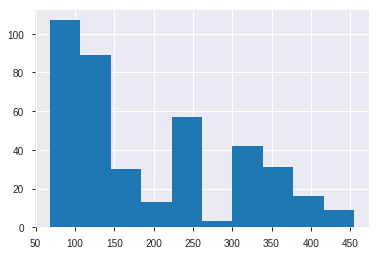

In [4]:
# Histogram of engine displacement
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

#TODO
X = auto['displacement'].tolist()

plt.hist(X)
plt.show()

<h3>Q.6. Normalize this feature by either applying Box-Cox transformation or any normalization tool from Scikit-learn. Plot this new feature to see whether it is now normally distributed.</h3>

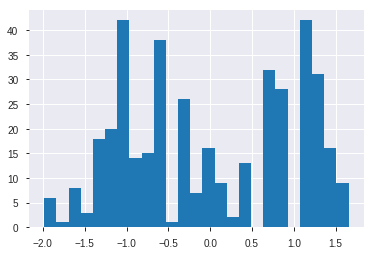

In [7]:
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
import matplotlib.pyplot as plt

pt = PowerTransformer(method='yeo-johnson', standardize=True) 

auto[['displacement']] = pt.fit_transform(auto[['displacement']])
auto
pt.lambdas_

X_New = auto['displacement'].tolist()

plt.hist(X_New, bins=25)
plt.show()

# Plot histogram of this new feature to reveal normal-like distribution

<h3>Q.7. Recalculate the Linear Regression model to predict mpg with the new feature and comment on its performance in comparison to the original model.</h3>

In [8]:
# Calculate then new model
### STATSMODELS ###

# create a fitted model with all the features
lm2 = smf.ols(formula='mpg ~ cylinders + displacement + horsepower + weight + acceleration + year + origin', data=auto[["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "year", "origin"]]).fit()

# print the coefficients
lm2.params

# print a summary of the fitted model
lm2.summary()

# Comment on its performance
# Adjusted R-Square value has improved. 
# p-value of displacement has also reduced from 0.011 to 0.000 which suggests stronger relationship for normalized displacement with mpg.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     274.4
Date:                Sat, 02 May 2020   Prob (F-statistic):          3.52e-146
Time:                        19:47:40   Log-Likelihood:                -1026.0
No. Observations:                 397   AIC:                             2068.
Df Residuals:                     389   BIC:                             2100.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -26.6941      4.683     -5.701      0.000     -35.901     -17.488
cylinders        0.8823      0.274      3.215      0.001       0.343       1.422
displacement    -3.2919      0.604     -5.451      0.000      -4.479      -2.105
horsepower      -0.0054      0.013     -0.433      0.666      -0.030       0.019
weight          -0.0042      0.001     -6.372      0.000      -0.006      -0.003
acceleration    -0.0050      0.096     -0.052      0.958      -0.193       0.183
year             0.7628      0.049     15.526      0.000       0.666       0.859
origin           0.3912      0.294      1.332      0.184      -0.186       0.968
==============================================================================
Omnibus:                       35.185   Durbin-Watson:                   1.311
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.078
Skew:                           0.437   Prob(JB):                     2.03e-19
Kurtosis:                       5.107   Cond. No.                     8.91e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.91e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<h3>Q.8. What is the mean and standard deviation for all the features?</h3>

In [37]:
auto.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
count,397.000000,397.000000,3.970000e+02,397.000000,397.000000,397.000000,397.000000,397.000000
mean,23.515869,5.458438,2.451999e-15,104.331234,2970.261965,15.555668,75.994962,1.574307
std,7.825804,1.701577,1.001262e+00,38.266994,847.904119,2.749995,3.690005,0.802549
min,9.000000,3.000000,-1.893530e+00,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,-8.989932e-01,76.000000,2223.000000,13.800000,73.000000,1.000000
50%,23.000000,4.000000,-1.907486e-01,93.500000,2800.000000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,8.714702e-01,125.000000,3609.000000,17.100000,79.000000,2.000000
max,46.600000,8.000000,1.713765e+00,230.000000,5140.000000,24.800000,82.000000,3.000000


<h3>Q.9. Center all the features, so that their mean is 0 and scale them, so that their standard deviation is 1. Recalculate the Linear Regression model, comment on its performance.</h3>

In [10]:
from sklearn import preprocessing

# Center and scale
cols = ["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "year", "origin"]
scaler = preprocessing.StandardScaler()
auto = scaler.fit_transform(auto)
auto = pd.DataFrame(auto, columns=cols)
print(auto.head())

# Recalculate the model
### STATSMODELS ###

# create a fitted model with all the features
lm3 = smf.ols(formula='mpg ~ cylinders + displacement + horsepower + weight + acceleration + year + origin', data=auto[["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "year", "origin"]]).fit()

# print the coefficients
lm3.params

# print a summary of the fitted model
lm3.summary()

# Comment on its performance
# Adjusted R-squared value hasn't improved. Standardisation hasn't improved the regression results.
# p-value for the Regression coefficients are all same.

        mpg  cylinders  displacement  horsepower    weight  acceleration  \
0 -0.705720   1.495535      1.119275    0.671627  0.630274     -1.294604   
1 -1.089551   1.495535      1.306234    1.587408  0.853457     -1.476652   
2 -0.705720   1.495535      1.170404    1.194930  0.549975     -1.658700   
3 -0.961608   1.495535      1.104889    1.194930  0.546432     -1.294604   
4 -0.833664   1.495535      1.095189    0.933279  0.565326     -1.840747   

       year    origin  
0 -1.626699 -0.716507  
1 -1.626699 -0.716507  
2 -1.626699 -0.716507  
3 -1.626699 -0.716507  
4 -1.626699 -0.716507  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     274.4
Date:                Sat, 02 May 2020   Prob (F-statistic):          3.52e-146
Time:                        19:49:00   Log-Likelihood:                -209.74
No. Observations:                 397   AIC:                             435.5
Df Residuals:                     389   BIC:                             467.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     7.893e-17      0.021   3.79e-15      1.000      -0.041       0.041
cylinders        0.1918      0.060      3.215      0.001       0.075       0.309
displacement    -0.4212      0.077     -5.451      0.000      -0.573      -0.269
horsepower      -0.0266      0.062     -0.433      0.666      -0.148       0.094
weight          -0.4576      0.072     -6.372      0.000      -0.599      -0.316
acceleration    -0.0018      0.034     -0.052      0.958      -0.068       0.064
year             0.3597      0.023     15.526      0.000       0.314       0.405
origin           0.0401      0.030      1.332      0.184      -0.019       0.099
==============================================================================
Omnibus:                       35.185   Durbin-Watson:                   1.311
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.078
Skew:                           0.437   Prob(JB):                     2.03e-19
Kurtosis:                       5.107   Cond. No.                         10.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<h3>Q.10. Create a new text cell in your Notebook: Complete a 50-100 word summary 
    (or short description of your thinking in applying this week's learning to the solution) 
     of your experience in this assignment. Include:
<br>                                                                       
What was your incoming experience with this model, if any?
what steps you took, what obstacles you encountered.
how you link this exercise to real-world, machine learning problem-solving. (What steps were missing? What else do you need to learn?)
This summary allows your instructor to know how you are doing and allot points for your effort in thinking and planning, and making connections to real-world work.
</h3>

I learnt the necessity of data cleaning and data transformation in this exercise. This is an important step in Machine learning.
I learnt how data transformation can improve the value of regression.

With this exercise, I also spent some extra time with different other steps that were shown to us in the class.
Overall applying the model was easy as we had done linear regression in previous class. Data cleaning and transformation part was interesting.
This exercise can be related to any machine learning problem in real world, as data cleaning and transformation is a very important step.
I would have liked to see how the performance of the model would have improved with removing the correlated features like:displacement and weight.